## Testing hypothesis 7
---

**_Hypothesis_**: Publishers are very specialized, so no publisher are able to get high scores (> 4.5) in more than 10 categories.

   - **Metric**: N. of times a publisher gets a score > 4.5 in different categories.
    
**Missing Values**:
  
- `publisher`: remove the entire sample
- `review/score`: remove the entire sample
- `categories`: remove the entire sample

**Data Transformation**:

- `categories`: GroupBy categories.
- `publisher`: GroupBy publisher.
- `review/score`: Compute the average review/score for each publisher.

---

In [133]:
# Connect to MongoDB

import pymongo

client = pymongo.MongoClient('mongodb://localhost:27017/')
database = client['spark_db']
books = database['books_hypothesis_7']

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Deal with missing values
pipeline_missing = {'$match':{
                         'review/score':{'$exists':True, '$ne':0.0},
                         'publisher':{'$exists':True, '$ne':None},
                         'categories':{'$exists':True},
                              }  
                    }    

# Compute average rating for each tuple category, publisher
pipeline_average_rating = {'$group':{
                                '_id':{
                                     'category':'$categories',
                                     'publisher':'$publisher',
                                     },
                                'avg_score':{'$avg':'$review/score'}
                                }
                           }

# Show average rating for category for each publisher
pipeline_publisher = {'$group': {
               '_id': '$_id.publisher',
               'avg_score/category': {
                    '$push': {
                         'category': '$_id.category',
                         'avg_score': '$avg_score'
                         }
                    }
               }
          }

# Unwind the list of categories
pipeline_unwind = {'$unwind':'$avg_score/category'}

# Count the number of categories with average rating > 4.5
pipeline_counts = {'$project': {
                         'publisher': '$_id',
                         '_id':0,
                         'category':'$avg_score/category.category',
                         'count': {
                              '$sum': {
                                   '$cond': {
                                   
                                        'if':{'$gt': ['$avg_score/category.avg_score', 4.5]},
                                        'then':1,
                                        'else':0
                                   }
                              }
                         }
                    }
               }

# Sum the results for each publisher. If Total > 10, then the hypothesis is False
pipeline_sum = {'$group': {
                    '_id': '$publisher', 
                    'total': {'$sum': '$count'}
                    }
                }

pipeline_sort = {'$sort':{
                         'total':-1
                         }
                }

results = books.aggregate([pipeline_missing, pipeline_average_rating, pipeline_publisher, pipeline_unwind, pipeline_counts, pipeline_sum, pipeline_sort])

df_results = pd.DataFrame(list(results))

In [148]:
df_results.head()

,_id,total
0,Random House,31
1,Oxford University Press USA,30
2,Vintage,23
3,Lulu com,20
4,Bantam,19


<AxesSubplot: title={'center': 'Number of categories with average rating > 4.5 for each publisher'}, xlabel='publisher'>

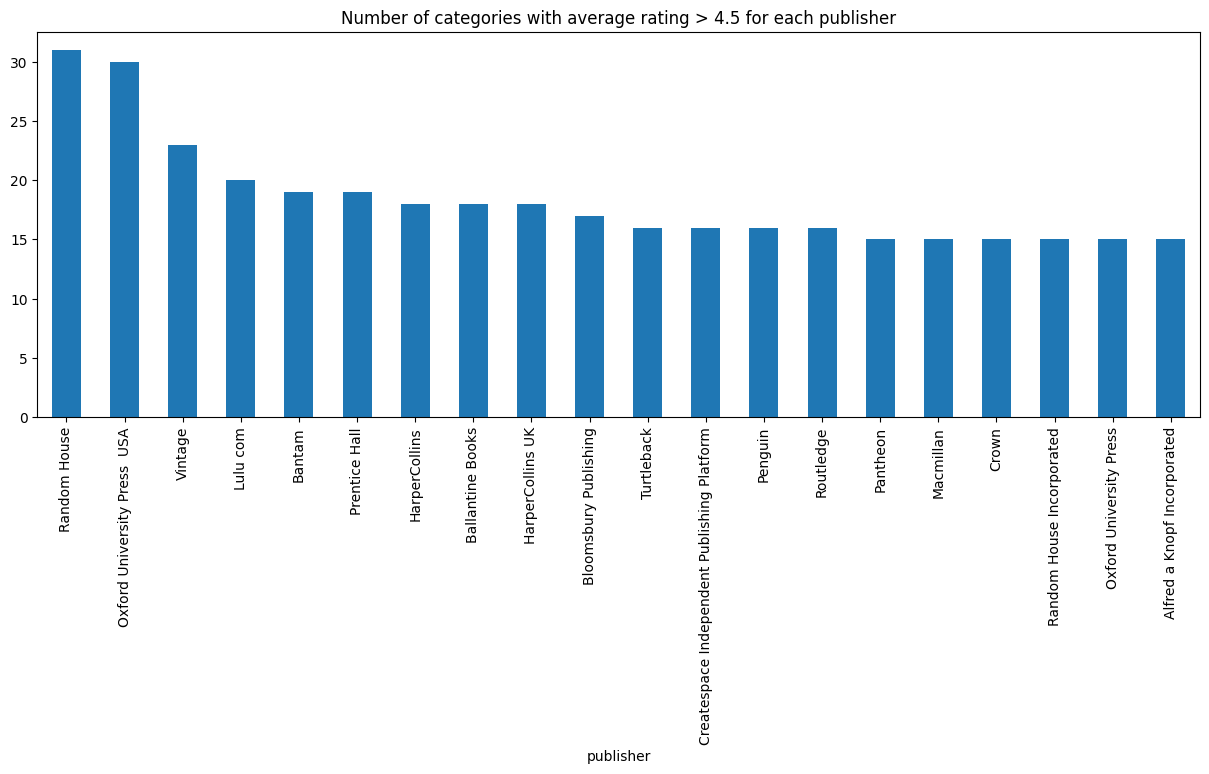

In [146]:
df_results.head(20).plot(x='_id', y='total', kind='bar', figsize=(15,5), xlabel = 'publisher', title='Number of categories with average rating > 4.5 for each publisher', legend=False)

## Deeper analysis focused on categories and publishers separately
---

### Analysis of categories

In [259]:
# Deal with missing values
pipeline_missing = {'$match':{
                         'review/score':{'$exists':True, '$ne':0.0},
                         'publisher':{'$exists':True, '$ne':None},
                         'categories':{'$exists':True},
                              }  
                    }    

# Compute average rating for each tuple category, publisher
pipeline_average_rating = {'$group':{
                                '_id':'$categories',
                                'avg_score':{'$avg':'$review/score'},
                                'count':{'$sum':1},
                                'titles':{'$addToSet':'$Title'}
                                }
                           }


pipeline_project = {'$project':{
                         '_id':0,
                         'category':'$_id',
                         'avg_score':1,
                         'count': 1,
                         'num_titles':{'$size':'$titles'}
                         }
                    }

pipeline_remove = {'$match':{
                         'count':{'$gt':100}
                              }  
                    }

results_2 = books.aggregate([pipeline_missing, pipeline_average_rating, pipeline_project, pipeline_remove])

df_results_2 = pd.DataFrame(list(results_2))
df_results_2.avg_score = df_results_2.avg_score*np.sqrt(df_results_2.num_titles)

In [260]:
df_results_2.sort_values(by='num_titles', ascending = False).head()

,avg_score,count,category,num_titles
35,419.761944,66512,Fiction,10424
63,228.449643,7618,Religion,2776
45,230.047024,16201,Juvenile Fiction,2664
41,218.258265,7052,History,2631
12,203.332740,8394,Biography Autobiography,2293


<AxesSubplot: title={'center': 'Number of reviews for each category'}, xlabel='category'>

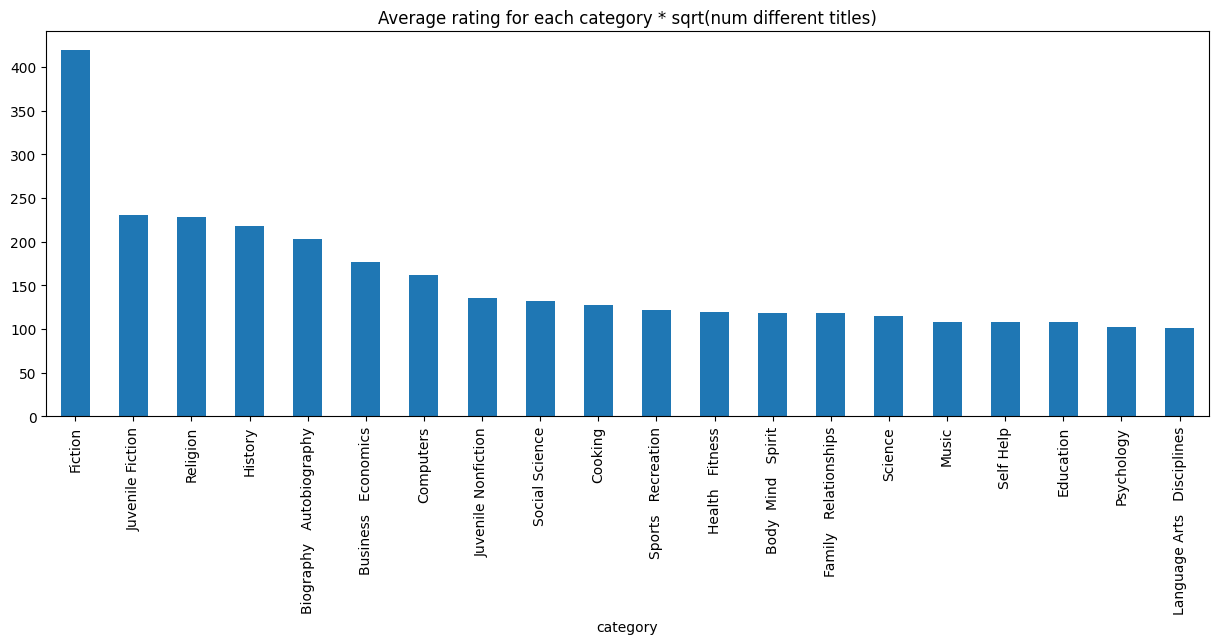

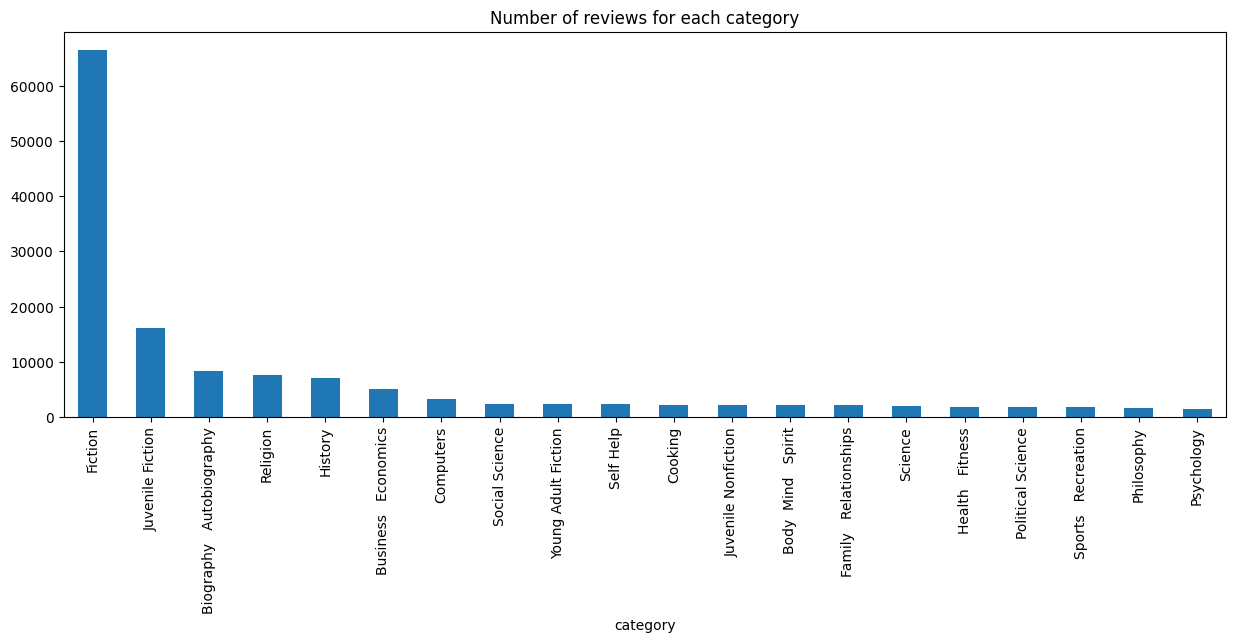

In [261]:
# Analyze the top 20 categories with the highest average rating
df_results_2.sort_values(by='avg_score', ascending = False, inplace=True)
df_results_2.head(20).plot(x='category', y='avg_score', kind='bar', figsize=(15,5), xlabel = 'category', title='Average rating for each category * sqrt(num different titles)', legend=False)

# Analyze the top 20 categories with the highest number of reviews
df_results_2.sort_values(by='count', ascending = False, inplace=True)
df_results_2.head(20).plot(x='category', y='count', kind='bar', figsize=(15,5), xlabel = 'category', title='Number of reviews for each category', legend=False)

### Analysis of publishers

In [256]:
# Deal with missing values
pipeline_missing = {'$match':{
                         'review/score':{'$exists':True, '$ne':0.0},
                         'publisher':{'$exists':True, '$ne':None},
                         'categories':{'$exists':True},
                              }  
                    }    

# Compute average rating for each tuple category, publisher
pipeline_average_rating = {'$group':{
                                '_id':'$publisher',
                                'avg_score':{'$avg':'$review/score'},
                                'count':{'$sum':1},
                                'titles':{'$addToSet':'$Title'}
                                }
                           }

pipeline_project = {'$project':{
                         '_id':0,
                         'publisher':'$_id',
                         'avg_score':1,
                         'count': 1,
                         'num_titles':{'$size':'$titles'}
                         }
                    }

pipeline_remove = {'$match':{
                         'count':{'$gt':100}
                              }  
                    }

results_2 = books.aggregate([pipeline_missing, pipeline_average_rating, pipeline_project, pipeline_remove])

df_results_2 = pd.DataFrame(list(results_2))
df_results_2.avg_score = df_results_2.avg_score*np.sqrt(df_results_2.num_titles)

In [257]:
df_results_2.head()

,avg_score,count,publisher,num_titles
0,40.712980,219,A C Black,96
1,24.508475,118,Abrams,36
2,42.572476,213,Addison Wesley Professional,98
3,19.981883,101,Aladdin,19
4,25.827367,149,Alfred a Knopf Incorporated,41


<AxesSubplot: title={'center': 'Number of reviews for each publisher'}, xlabel='publisher'>

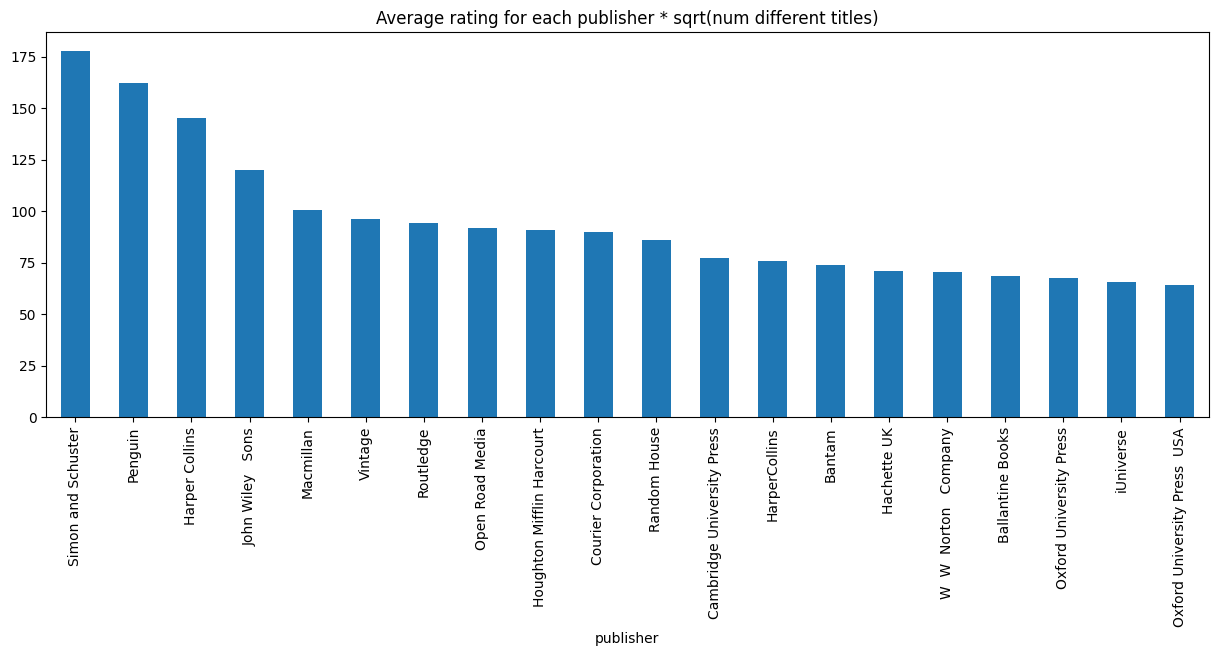

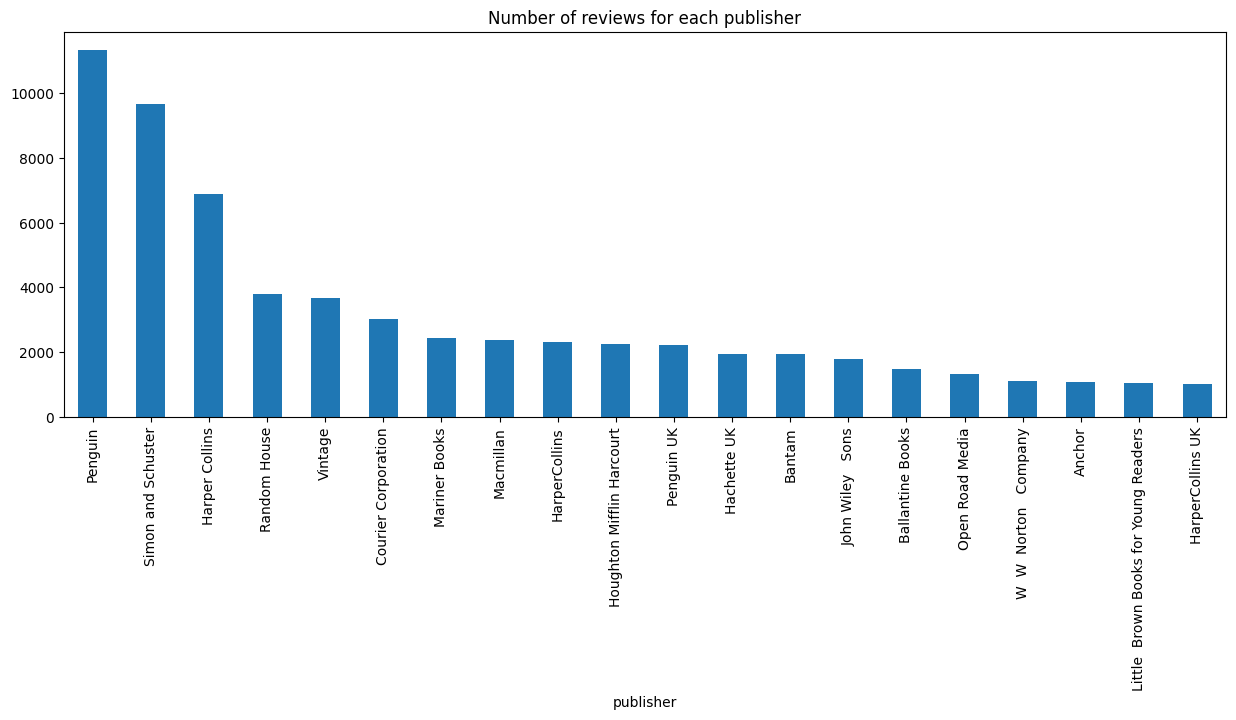

In [258]:
# Analyze the top 20 publishers with the highest average rating
df_results_2.sort_values(by='avg_score', ascending = False, inplace=True)
df_results_2.head(20).plot(x='publisher', y='avg_score', kind='bar', figsize=(15,5), xlabel = 'publisher', title='Average rating for each publisher * sqrt(num different titles)', legend=False)

# Analyze the top 20 publishers with the highest number of reviews
df_results_2.sort_values(by='count', ascending = False, inplace=True)
df_results_2.head(20).plot(x='publisher', y='count', kind='bar', figsize=(15,5), xlabel = 'publisher', title='Number of reviews for each publisher', legend=False)

In [236]:
p = {'$group':{'_id':'$publisher', 'titles':{'$addToSet':'$Title'}}}

t = books.aggregate([p])

b = pd.DataFrame(list(t))
b

,_id,titles
0,None,"[Lieutenant Hornblower, History of Bedford and..."
1,010 Publishers,[Delight]
2,1 881713 71 7,[Menudo el reencuentro con la verdad Spanish...
3,1st Book Library,[Birth of a Tumbleweed Memoirs of Growing Up ...
4,1st World Publishing,"[The voyage out, Mother stories, A PEEP BEHIND..."
...,...,...
7347,北戴河出版,"[The Economic Consequences of the Peace, The E..."
7348,成甲書房,[The Quest For Viable Peace International Int...
7349,清华大学出版社有限公司,[Software Project Management in Practice]
7350,秀和システム,[Costa Rican Wildlife An Introduction to Fami...
